# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import statistics
import powerlaw

# Load Data

In [2]:
# Dataset 1: Original dataset
edges1 = pd.read_csv('output/prev_kg_edges.csv', header=0)
print(f'Loaded {edges1.shape[0]} edges from dataset 1 with columns:', edges1.columns.values)

nodes1 = pd.read_csv('output/prev_kg_nodes.csv', header=0)
print(f'Loaded {nodes1.shape[0]} nodes from dataset 1 with columns:', nodes1.columns.values)

print('\n')

# Dataset 2: Restructured dataset
edges2 = pd.read_csv('output/new_kg_edges.csv', header=0)
print(f'Loaded {edges2.shape[0]} edges from dataset 2 with columns:', edges2.columns.values)

nodes2 = pd.read_csv('output/new_kg_nodes.csv', header=0)
print(f'Loaded {nodes2.shape[0]} nodes from dataset 2 with columns:', nodes2.columns.values)

Loaded 82944 edges from dataset 1 with columns: ['id' 'subject' 'object' 'relation_id' 'relation_label' 'relation_iri']
Loaded 10034 nodes from dataset 1 with columns: ['id' 'label' 'iri' 'semantic' 'taxon_id' 'taxon_label']


Loaded 85992 edges from dataset 2 with columns: ['id' 'subject' 'object' 'relation_id' 'relation_label' 'relation_iri']
Loaded 10275 nodes from dataset 2 with columns: ['id' 'label' 'iri' 'semantic']


# Node Types and Edge Types Occurrences

Count node types

In [3]:
def count_node_types(nodes: pd.DataFrame, set_name, save=False):
    node_type_count = pd.DataFrame()
    
    total_nodes = nodes.shape[0]
    
    counts = nodes['semantic'].value_counts()
    
    for indx, value in counts.items():
        count_dict = {
            'Node Type': indx,
            'Count': value,
            'Percentage': value / total_nodes * 100
        }
        node_type_count = pd.concat([node_type_count, pd.DataFrame([count_dict])], ignore_index=True)
    
    node_type_count['Percentage'] = node_type_count['Percentage'].transform(lambda x: '{:,.2f}%'.format(x))
    
    if save:
        node_type_count.to_csv(f'output/node_types_{set_name}.csv', index=False)
    
    return node_type_count

In [4]:
node_types_1 = count_node_types(nodes1, 1)
node_types_1

,Node Type,Count,Percentage
0,DISO,5146,51.29%
1,ORTH,2880,28.70%
2,VARI,1125,11.21%
3,GENO,409,4.08%
4,DRUG,202,2.01%
5,GENE,202,2.01%
6,PHYS,50,0.50%
7,ANAT,20,0.20%


In [5]:
node_types_2 = count_node_types(nodes2, 2)
node_types_2

,Node Type,Count,Percentage
0,phenotype,5311,51.69%
1,gene,3163,30.78%
2,variant,1277,12.43%
3,drug,291,2.83%
4,biological artifact,71,0.69%
5,gene product,38,0.37%
6,genotype,36,0.35%
7,taxon,26,0.25%
8,biological process,24,0.23%
9,cellular component,17,0.17%


Count edge types

In [6]:
def count_edge_types(edges: pd.DataFrame, set_name):
    edge_type_count = pd.DataFrame()
    
    total_edges = edges.shape[0]
    
    counts = edges['relation_label'].value_counts()
    
    for indx, value in counts.items():
        count_dict = {
            'Edge Type': indx,
            'Count': value,
            'Percentage': value / total_edges * 100
        }
        edge_type_count = pd.concat([edge_type_count, pd.DataFrame([count_dict])], ignore_index=True)
    
    edge_type_count['Percentage'] = edge_type_count['Percentage'].transform(lambda x: '{:,.2f}%'.format(x))
    edge_type_count.to_csv(f'output/edge_types_{set_name}.csv', index=False)
    
    return edge_type_count

In [7]:
count_edge_types(edges1, 1)

,Edge Type,Count,Percentage
0,in 1 to 1 orthology relationship with,29817,35.95%
1,in orthology relationship with,24020,28.96%
2,has phenotype,14520,17.51%
3,interacts with,7813,9.42%
4,is part of,1342,1.62%
5,has affected feature,1106,1.33%
6,pathogenic for condition,986,1.19%
7,expressed in,981,1.18%
8,enables,872,1.05%
9,involved in,405,0.49%


In [8]:
count_edge_types(edges2, 2)

,Edge Type,Count,Percentage
0,in orthology relationship with,53837,62.61%
1,causes condition,15361,17.86%
2,interacts with,7813,9.09%
3,found in,3163,3.68%
4,is part of,1342,1.56%
5,has affected feature,1106,1.29%
6,enables,872,1.01%
7,contributes to condition,786,0.91%
8,involved in,451,0.52%
9,targets,357,0.42%


# Create Graph

## Merge nodes with edges

In [9]:
def get_kg(edges: pd.DataFrame, nodes: pd.DataFrame):
    assert 'subject' in list(edges.columns.values)
    assert 'object' in list(edges.columns.values)
    assert 'id' in list(nodes.columns.values)
    
    kg_df = pd.merge(edges, nodes,
                     left_on='subject', right_on='id',
                     how='inner')
    
    kg_df = kg_df.copy()[['id_x', 'subject', 'semantic', 'relation_id', 'relation_label', 'object']]
    kg_df = kg_df.rename(columns={'id_x': 'edge_id', 'subject': 'subject_id', 'semantic': 'subject_class'})
    
    kg_df = pd.merge(kg_df, nodes,
                     left_on='object', right_on='id',
                     how='inner')
    
    kg_df = kg_df.copy()[['edge_id', 'subject_id', 'subject_class', 'relation_id', 'relation_label', 'object', 'semantic']]
    kg_df = kg_df.rename(columns={'object': 'object_id', 'semantic': 'object_class'})
    
    return kg_df

In [10]:
kg_df1 = get_kg(edges1, nodes1)
kg_df1

,edge_id,subject_id,subject_class,relation_id,relation_label,object_id,object_class
0,MONARCH75386,ZFIN:ZDB-GENE-050626-112,ORTH,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
1,MONARCH23115,RGD:1598796,ORTH,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
2,MONARCH70270,ZFIN:ZDB-GENE-000322-6,ORTH,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
3,MONARCH8710,NCBIGene:396067,GENE,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
4,MONARCH80383,dictyBase:DDB_G0277859,GENO,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
...,...,...,...,...,...,...,...
82908,MONARCH39537,dbSNP:rs9975725,GENO,GENO:0000418,has affected feature,ENSEMBL:ENSG00000231236,ORTH
82909,MONARCH64645,dbSNP:rs35396788,GENO,GENO:0000418,has affected feature,HGNC:26832,GENE
82910,MONARCH26352,dbSNP:rs7960954,GENO,GENO:0000418,has affected feature,HGNC:53337,GENE
82911,MONARCH51369,MGI:3531484,ORTH,NaN,NaN,MGI:3573782,ORTH


In [11]:
kg_df2 = get_kg(edges2, nodes2)
kg_df2

,edge_id,subject_id,subject_class,relation_id,relation_label,object_id,object_class
0,15a20d1b-1d4c-4ef5-8960-0bbcee1b4261,WormBase:WBGene00006787,gene,RO:0002434,interacts with,WormBase:WBGene00003929,gene
1,7e4c8a99-42a0-4781-97b0-1db60b70611d,WormBase:WBGene00000051,gene,RO:0002434,interacts with,WormBase:WBGene00003929,gene
2,f5df3058-4a07-47b4-88aa-3d176288abf9,WormBase:WBGene00001328,gene,RO:0002434,interacts with,WormBase:WBGene00003929,gene
3,318ad340-8d15-4f97-9e2a-1f24aa6ef5fa,WormBase:WBGene00000042,gene,RO:0002434,interacts with,WormBase:WBGene00003929,gene
4,c08542cd-647f-4ffe-bdcc-d1d8f2a6cd92,FlyBase:FBgn0001250,gene,RO:HOM0000017,in orthology relationship with,WormBase:WBGene00003929,gene
...,...,...,...,...,...,...,...
85987,b7552581fa3d846ace8e6948f4d86664,1906,drug,CustomRO:TTD2,targets,Q8IXJ6,gene product
85988,50e562ac0c69b0126dc686f69de889b9,2966,drug,CustomRO:TTD2,targets,Q8IXJ6,gene product
85989,b039e2951b5993debf77c79470f511b2,1795,drug,CustomRO:TTD2,targets,P02768,gene product
85990,411753776f05434e63ed9f33a9b7aeab,4728,drug,CustomRO:TTD2,targets,P48050,gene product


## Check for duplicates in edges

For dataset 1

In [12]:
assocs1 = pd.read_csv('prev/monarch/monarch_connections_v2023-02-20.csv')
assocs1[assocs1.duplicated(['subject_id', 'object_id', 'relation_label'], keep=False)][['subject_id', 'object_id', 'relation_label']].sort_values(by=['subject_id', 'object_id', 'relation_label'])

,subject_id,object_id,relation_label


In [38]:
kg_df1[kg_df1.duplicated(['subject_id', 'object_id', 'relation_label'], keep=False)]

,edge_id,subject_id,subject_class,relation_id,relation_label,object_id,object_class


For dataset 2, the raw associations fetched from Monarch Initiative already contain duplicates despite havong a different association ID.

In [39]:
assocs = pd.read_csv('output/monarch_associations.csv', header=0)
assocs[assocs.duplicated(['subject_id', 'object_id', 'relation_label'], keep=False)][['id', 'subject_id', 'object_id', 'relation_label']].sort_values(by=['subject_id', 'object_id', 'relation_label'])

,id,subject_id,object_id,relation_label
25742,cc938f17-3373-4a6f-9b61-3172dde2ee76,FlyBase:FBal0002369,MONDO:0010679,has role in modeling
32761,6bf7166d-6ed2-443c-a2ec-56af3d73c85c,FlyBase:FBal0002369,MONDO:0010679,has role in modeling
27384,aec7d719-0aab-4dae-8da7-f56b7399a7dc,FlyBase:FBal0216503,MONDO:0010679,has role in modeling
41956,b1a9848e-c4ed-4704-8e5f-3f1b899477a6,FlyBase:FBal0216503,MONDO:0010679,has role in modeling
25985,76f6d0e3-0430-4cc2-af82-ce602732b06d,FlyBase:FBal0244098,MONDO:0010679,has role in modeling
...,...,...,...,...
74436,72afef59-d66e-4bdb-8667-d152e918fd27,ZFIN:ZDB-FISH-150901-18332,MONDO:0010679,has role in modeling
8492,c831abf6-850f-4667-a927-7ff9acece9a1,ZFIN:ZDB-FISH-150901-25829,MONDO:0010679,has role in modeling
28785,86ecd6c3-9aba-43d1-bc3a-98bee384d5c8,ZFIN:ZDB-FISH-150901-25829,MONDO:0010679,has role in modeling
37466,d2ca266d-ee72-40eb-ae71-2b6154982061,ZFIN:ZDB-FISH-150901-8844,MONDO:0010679,has role in modeling


In [40]:
kg_df2[kg_df2.duplicated(['subject_id', 'object_id', 'relation_label'], keep=False)][['subject_id', 'object_id', 'relation_label']].sort_values(by=['subject_id', 'object_id', 'relation_label'])

,subject_id,object_id,relation_label
11698,FlyBase:FBal0002369,MONDO:0010679,has role in modeling
11699,FlyBase:FBal0002369,MONDO:0010679,has role in modeling
12078,FlyBase:FBal0216503,MONDO:0010679,has role in modeling
12079,FlyBase:FBal0216503,MONDO:0010679,has role in modeling
11770,FlyBase:FBal0244098,MONDO:0010679,has role in modeling
...,...,...,...
12193,ZFIN:ZDB-FISH-150901-18332,MONDO:0010679,has role in modeling
11988,ZFIN:ZDB-FISH-150901-25829,MONDO:0010679,has role in modeling
11989,ZFIN:ZDB-FISH-150901-25829,MONDO:0010679,has role in modeling
11776,ZFIN:ZDB-FISH-150901-8844,MONDO:0010679,has role in modeling


Generate graph objects for both datasets.

In [13]:
def get_graph(edgelist: pd.DataFrame, nodelist: pd.DataFrame):
    assert 'subject_id' in list(edgelist.columns.values)
    assert 'object_id' in list(edgelist.columns.values)
    assert 'relation_label' in list(edgelist.columns.values)
    assert 'edge_id' in list(edgelist.columns.values)
    
    G = nx.from_pandas_edgelist(edgelist, source='subject_id', target='object_id', edge_attr='relation_label',
                                create_using=nx.DiGraph(), edge_key='edge_id')
    
    node_attrs = {}
    for ind, node in nodelist.iterrows():
        attr_dict = {'class': node.semantic}
        node_attrs[node.id] = attr_dict
        
    nx.set_node_attributes(G, node_attrs)
    
    for node in G.nodes(data=True):
        print('First node in graph:', node)
        break

    for edge in G.edges(data=True):
        print('First edge in graph:', edge)
        break

    print('Total number of edges is {}'.format(G.number_of_edges()))
    print('Total number of nodes is {}'.format(G.number_of_nodes()))

    return G

In [14]:
print('Dataset 1 graph:')
G1 = get_graph(kg_df1, nodes1)
print('Dataset 2 graph:')
G2 = get_graph(kg_df2, nodes2)

Dataset 1 graph:
First node in graph: ('ZFIN:ZDB-GENE-050626-112', {'class': 'ORTH'})
First edge in graph: ('ZFIN:ZDB-GENE-050626-112', 'FlyBase:FBgn0085464', {'relation_label': 'in orthology relationship with'})
Total number of edges is 82899
Total number of nodes is 10034
Dataset 2 graph:
First node in graph: ('WormBase:WBGene00006787', {'class': 'gene'})
First edge in graph: ('WormBase:WBGene00006787', 'WormBase:WBGene00003929', {'relation_label': 'interacts with'})
Total number of edges is 85878
Total number of nodes is 10275


In [15]:
nx.write_gexf(G1, "g1.gexf")

In [16]:
nx.write_gexf(G2, "g2.gexf")


# Plots

In [85]:
def plot_degree_histogram(G, title):
    degree_freq = nx.degree_histogram(G)
    
    sorted_degree_freq = sorted(degree_freq, reverse=True)
    fit = powerlaw.Fit(sorted_degree_freq)
    
    plt.figure(figsize=(8, 6))
    
    fig = fit.plot_pdf(color='b', linewidth=2)
    fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig)
    
    alpha = '{:.2f}'.format(fit.power_law.alpha)
    
    fig.set_title(f'{title} Fit Onto Power Law with α={alpha}', fontdict={'fontsize': 10})
    
    degrees = range(len(degree_freq))

    plt.figure(figsize=(8, 6)) 
    
    plt.loglog(degrees[1:], degree_freq[1:], linewidth = '1')
    plt.xlabel('(Log) Degree')
    plt.ylabel('(Log) Frequency')
    plt.title(title)
    plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


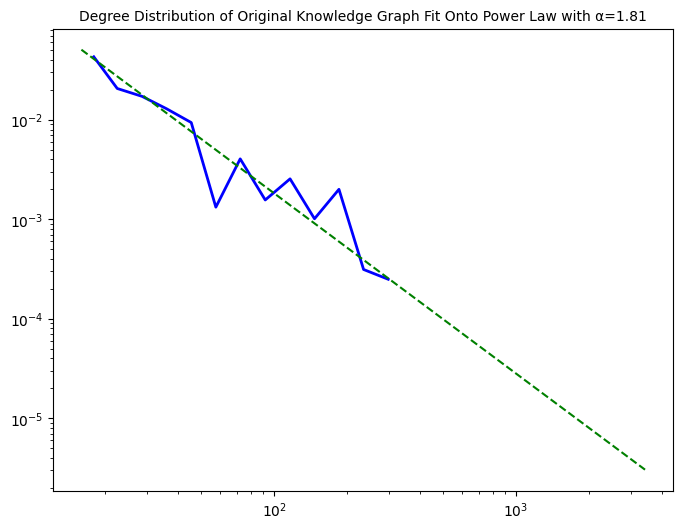

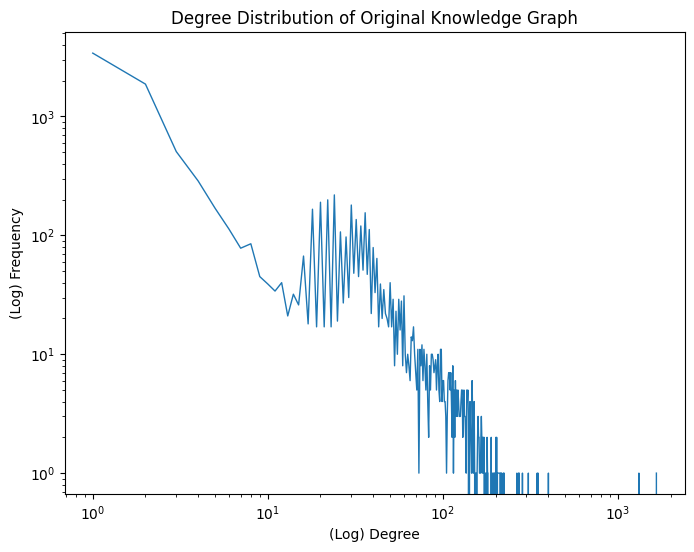

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


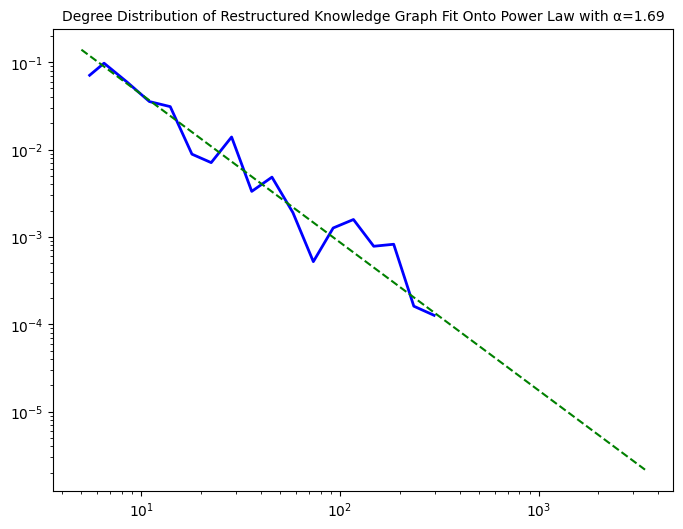

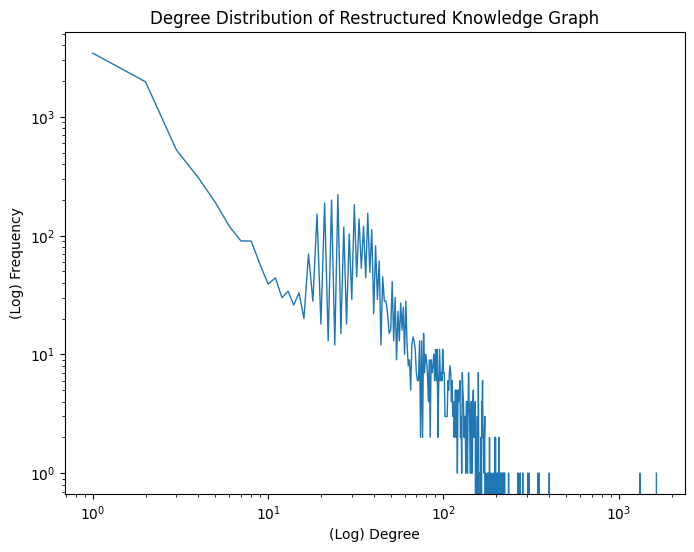

In [86]:
plot_degree_histogram(G1, 'Degree Distribution of Original Knowledge Graph')
plot_degree_histogram(G2, 'Degree Distribution of Restructured Knowledge Graph')

# Global Statistics

The density statistic represents the proportion of possible relationships in the network that are actually present. The value ranges from 0 to 1, with the lower limit corresponding to networks with no relationships and the upper limit representing networks with all possible relationships. The closer the value is to 1, the more dense is the network and the more cohesive are the nodes in the network.

In [16]:
density_G1 = nx.density(G1)
density_G2 = nx.density(G2)

print('Density of G1:', density_G1)
print('Density of G2:', density_G2)

Density of G1: 0.0008234635549209435
Density of G2: 0.0008135055678780964


In [33]:
avg_clu_coeff_G1 = nx.average_clustering(G1)
avg_clu_coeff_G2 = nx.average_clustering(G2)

print('Average Clustering Coefficient of G1:', avg_clu_coeff_G1)
print('Average Clustering Coefficient of G2:', avg_clu_coeff_G2)

Average Clustering Coefficient of G1: 0.32462748345663617
Average Clustering Coefficient of G2: 0.2989652750417442


The diameter of a network is the maximum length of any shortest path between an input and an output.

In [31]:
diam_G1 = nx.diameter(G1.to_undirected())
diam_G2 = nx.diameter(G2.to_undirected())

print('Diameter of G1:', diam_G1)
print('Diameter of G2:', diam_G2)

Diameter of G1: 7
Diameter of G2: 7


In [34]:
path_length_G1 = nx.average_shortest_path_length(G1.to_undirected())
path_length_G2 = nx.average_shortest_path_length(G2.to_undirected())

print('Average shortest path length of G1:', path_length_G1)
print('Average shortest path length of G2:', path_length_G2)

Average shortest path length of G1: 3.7765212947562063
Average shortest path length of G2: 3.752913924881602


In [30]:
def get_avg_degree(G):
    degrees = G.degree()
    count = 0
    degrees_total = 0

    for _, value in degrees:
        count += 1
        degrees_total += value
        
    return degrees_total / count

def get_highest_degree(G):
    degrees = G.degree()
    highest_degree = 0

    for _, value in degrees:
        if value > highest_degree:
            highest_degree = value
        
    return highest_degree

def get_median_degree(G):
    degrees = G.degree()
    all_degrees = []
    
    for _, value in degrees:
        all_degrees.append(value)
        
    return statistics.median(all_degrees)

print('Average degree of G1:', get_avg_degree(G1))
print('Median degree of G1:', get_median_degree(G1))
print('Highest degree of G1:', get_highest_degree(G1))

print('Average degree of G2:', get_avg_degree(G2))
print('Median degree of G2:', get_median_degree(G2))
print('Highest degree of G2:', get_highest_degree(G2))

Average degree of G1: 16.523619693043653
Median degree of G1: 2.0
Highest degree of G1: 1660
Average degree of G2: 16.715912408759124
Median degree of G2: 2
Highest degree of G2: 1637


In [35]:
def fill_semantic_dict(semantic_dict, semantic, add_value):
    if semantic in semantic_dict:
        semantic_dict[semantic] += add_value
    else:
        semantic_dict[semantic] = add_value
        
    return semantic_dict

def fill_semantic_dict2(semantic_dict, semantic, append_value):
    if semantic in semantic_dict:
        semantic_dict[semantic].append(append_value)
    else:
        semantic_dict[semantic] = [append_value]
        
    return semantic_dict

def get_degree_per_semantic(G, nodes, set_name, save=False):
    degrees = G.degree()
    semantic_degrees = {}
    semantic_totals = {}
    semantic_degree_per_node = {}

    for node_degree in degrees:
        node_id, degree = node_degree
        
        node_info = nodes.loc[nodes['id'] == node_id]
        node_semantic = node_info['semantic'].values[0]
        
        semantic_totals = fill_semantic_dict(semantic_totals, node_semantic, 1)
        semantic_degrees = fill_semantic_dict(semantic_degrees, node_semantic, degree)
        semantic_degree_per_node = fill_semantic_dict2(semantic_degree_per_node, node_semantic, degree)
    
    semantic_degrees_list = []
    for k in semantic_degrees.keys():
        avg_degree = semantic_degrees[k] / semantic_totals[k]
        
        median_degree = statistics.median(semantic_degree_per_node[k])
        
        semantic_degrees_list.append([k, avg_degree, median_degree])
        
    semantic_degrees_df = pd.DataFrame(semantic_degrees_list, columns = ['Node Type' , 'Average Degree', 'Median Degree'])
    semantic_degrees_df['Average Degree'] = semantic_degrees_df['Average Degree'].transform(lambda x: '{:,.2f}'.format(x))
    
    if save:
        semantic_degrees_df.to_csv(f'output/node_degrees_{set_name}.csv', index=False)
    
    return semantic_degrees_df

In [36]:
node_degrees_1 = get_degree_per_semantic(G1, nodes1, 1)
node_degrees_1

,Node Type,Average Degree,Median Degree
0,ORTH,41.26,32.0
1,GENE,99.37,79.5
2,GENO,12.17,2.0
3,PHYS,52.96,22.5
4,ANAT,49.05,27.0
5,DISO,3.07,1.0
6,VARI,1.98,2.0
7,DRUG,1.23,1.0


In [37]:
node_degrees_2 = get_degree_per_semantic(G2, nodes2, 2)
node_degrees_2

,Node Type,Average Degree,Median Degree
0,gene,45.73,35.0
1,phenotype,2.86,1.0
2,variant,2.30,2.0
3,disease,130.42,18.5
4,genotype,15.94,11.5
5,biological process,16.88,8.5
6,taxon,124.38,154.5
7,biological artifact,2.35,2.0
8,drug,1.45,1.0
9,gene product,10.39,5.0


In [38]:
def get_semantic_stats(node_types, node_degrees, set_name):
    df = pd.merge(node_types, node_degrees, left_on='Node Type', right_on='Node Type', how='inner')
    
    df.to_csv(f'output/node_type_stats_{set_name}.csv', index=False)
    
    return df    

In [39]:
get_semantic_stats(node_types_1, node_degrees_1, 1)

,Node Type,Count,Percentage,Average Degree,Median Degree
0,DISO,5146,51.29%,3.07,1.0
1,ORTH,2880,28.70%,41.26,32.0
2,VARI,1125,11.21%,1.98,2.0
3,GENO,409,4.08%,12.17,2.0
4,DRUG,202,2.01%,1.23,1.0
5,GENE,202,2.01%,99.37,79.5
6,PHYS,50,0.50%,52.96,22.5
7,ANAT,20,0.20%,49.05,27.0


In [40]:
get_semantic_stats(node_types_2, node_degrees_2, 2)

,Node Type,Count,Percentage,Average Degree,Median Degree
0,phenotype,5311,51.69%,2.86,1.0
1,gene,3163,30.78%,45.73,35.0
2,variant,1277,12.43%,2.30,2.0
3,drug,291,2.83%,1.45,1.0
4,biological artifact,71,0.69%,2.35,2.0
5,gene product,38,0.37%,10.39,5.0
6,genotype,36,0.35%,15.94,11.5
7,taxon,26,0.25%,124.38,154.5
8,biological process,24,0.23%,16.88,8.5
9,cellular component,17,0.17%,78.94,50.0


# Graph Visualization

In [105]:
def get_metagraph(edgelist: pd.DataFrame, dataset: int):
    assert 'object_class' in list(edgelist.columns.values)
    assert 'subject_class' in list(edgelist.columns.values)
    assert 'relation_label' in list(edgelist.columns.values)

    metagraph = edgelist[['object_class', 'subject_class', 'relation_label']]
    metagraph = metagraph.drop_duplicates().reset_index()
    
    G = nx.MultiGraph()
    for ind, edge in metagraph.iterrows():
        G.add_edge(edge['object_class'], edge['subject_class'], edge_label=edge['relation_label'])
    
    if dataset == 1:
        d = {
                'ORTH': 0, 
                'DISO': 1, 
                'GENE': 2, 
                'GENO': 3, 
                'VARI': 4, 
                'ANAT': 5, 
                'DRUG':6 , 
                'PHYS': 7}
        font_color = 'white'
        cmap_name = 'viridis'
    else:
        d = {
                'molecular function': 0, 
                'cellular component': 1, 
                'taxon': 2,
                'biological artifact': 3,
                'gene': 4,
                'genotype': 5,
                'variant': 6,
                'disease': 7,
                'phenotype': 8,
                'biological process': 9,
                'gene product': 10,
                'drug': 11
            }
        font_color = 'black'
        cmap_name = 'Spectral'
    values = [d.get(node, 0.25) for node in G.nodes()]
    
    plt.figure(figsize=(7,7))
    nx.draw(G, cmap=plt.get_cmap(cmap_name), node_color=values, font_color=font_color, font_size=7, with_labels=True, node_size=1600)

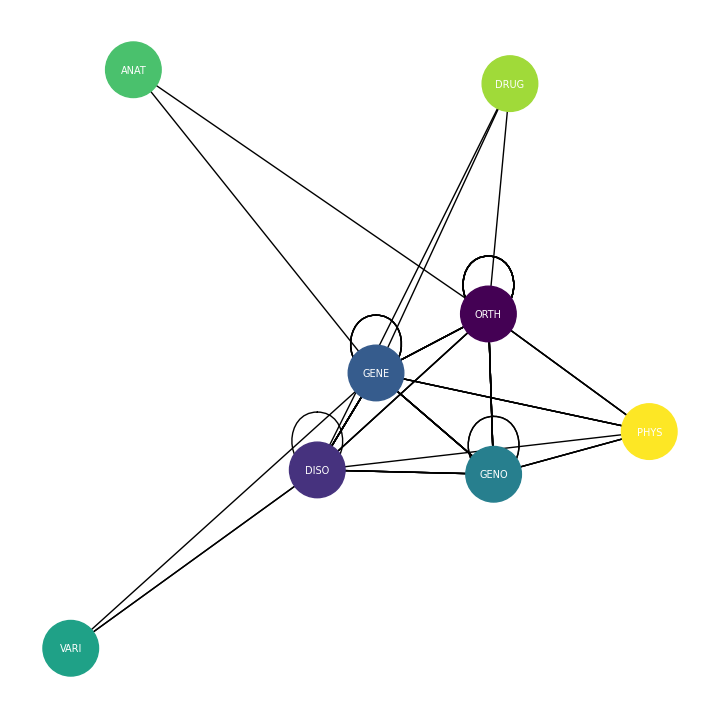

In [106]:
get_metagraph(kg_df1, 1)

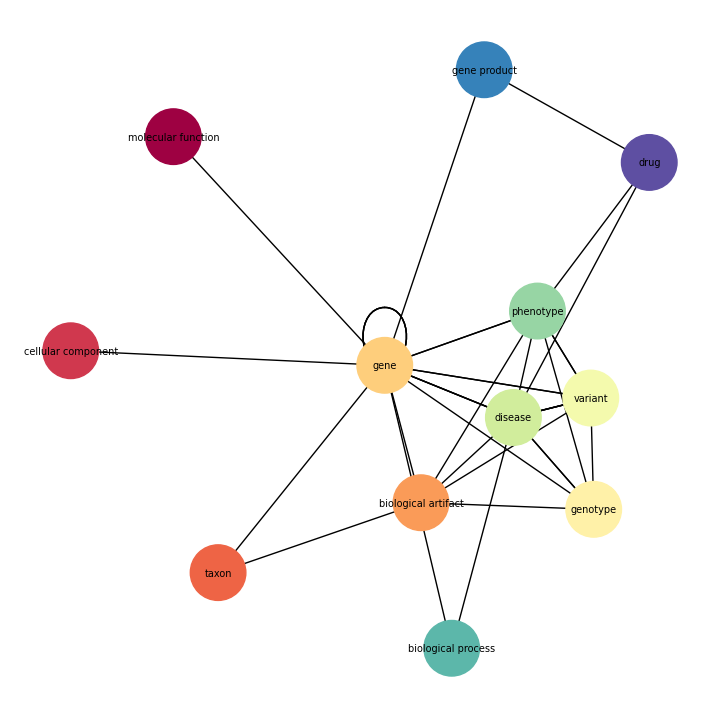

In [107]:
get_metagraph(kg_df2, 2)

# Edge2Vec Edge Type Transition Matrix Comparison

In [2]:
M2 = np.load('output/transitionmatrix_2.npy')

In [4]:
M2.shape

(21, 21)